# Inleveropgave 2: Model-Free Prediction and Control

## Model-Free Control

### Sources:
- https://www.baeldung.com/cs/ml-policy-reinforcement-learning
- https://github.com/djbyrne/MonteCarlo
- https://oneraynyday.github.io/ml/2018/05/24/Reinforcement-Learning-Monte-Carlo/#first-visit-monte-carlo

In [1]:
from typing import Tuple, List
from utils import Maze, show_policy
from collections import defaultdict

import random as rd
import numpy as np
import matplotlib.pyplot as plt

Eerst worden de action space, de end states en de environment zelf neergezet.

In [2]:
start_state = (3, 2)
terminal_states = [(0, 3), (3, 0)]
actions = ["up", "right", "left", "down"]

rewards = np.array([[-1, -1, -1, 40],
                    [-1, -1, -10, -10],
                    [-1, -1, -1, -1],
                    [10, -2, -1, -1]])

# initialize the Maze
maze = Maze(rewards, terminal_states, start_state)

### De epsilon greedy policy e de generatie van een episode

In [3]:
def epsilon_greedy_step(q_table: defaultdict, state: Tuple[int, int], epsilon: float) -> Tuple[int, int]:
    """Takes an action based on the epsilon greedy policy and the q-table.
    
    args:
        q_table (defaultdict): The Q-table with the policy.
        state (Tuple[int, int]): The current state from which the next action should be made.
        epsilon (float): The rate of exploration.

    returns:
        Tuple[int, int]: Returns the intended action and the final action taken.
    """
    if epsilon > rd.random():
        # exploring
        action = rd.randint(0, len(q_table[state]) - 1)
    else:
        # choosing greedy
        action = np.argmax(q_table[state])
    
    return action
        

def generate_episode(env: Maze, q_table: defaultdict, epsilon: float) -> List[Tuple[Tuple[int, int], Tuple[int, int], int]]:
    """Generates an episode based on the epsilon greedy policy.

    args:
        env (Maze): The environment which holds all the rewards and states.
        q_table (defaultdict): The Q-table with the policy.
        epsilon (float): The rate of exploration.

    returns:
        List[Tuple[Tuple[int, int], Tuple[int, int], int]]: Returns a list with all the state-action pairs with the corresponding rewards.
    """
    steps = []  # holds Tuples with the states, actions and rewards
    pos = env.get_random_position()

    # break if the chosen state is a terminal state
    while pos not in env.end_states:
        
        # get the next action
        action = epsilon_greedy_step(q_table, pos, epsilon)
        next_actions = env.get_next_action_positions(pos)
        
        # get the reward of the state where the action leads to
        reward = env.R[next_actions[action]]
        
        # save the current step
        steps.append((pos, action, reward))

        # update the pos to the taken action
        pos = next_actions[action]
        
    # save the latest pos with all extra data
    steps.append((pos, (), 0))
    # print(steps)
    return steps

### On-policy first-visit Monte-Carlo Control

In [4]:
def on_policy_fv_mc_control(env: Maze, actions: List[str], discount: float = 0.9,
                            epsilon: float = 0.3, n_episodes: int = 10000):
    """A function that uses on-policy first-visit MC control to optimise for the best policy.
    
    args:
        env (Maze): The environment which holds the rewards of all the possible states.
        actions (List[str]): The action space.
        discount (float, optional): The discount factor. Defaults to 0.9.
        epsilon (float, optional): The rate of exploration. Defaults to 0.3.
        n_episodes (int, optional): The amount of episodes to run. Defaults to 10000.       

    returns:
        default_dict: The Q-table with the policy.
    """
    # set up the qtable and the state-action returns
    policy_Q = defaultdict(lambda: np.zeros(len(actions)))
    mean_Q = defaultdict(lambda: np.zeros(len(actions)))
    state_returns = defaultdict(list)
    
    for _ in range(n_episodes):
        episode = generate_episode(env, policy_Q, epsilon)
        visited_qstates = []
        G = 0

        for state, action, reward in episode[::-1]:
            G = discount * G + reward

            if (state, action) not in visited_qstates:
                # the state-action haven't appeared yet
                visited_qstates.append((state, action))  # add state action pair to visited
                # update the return of the state action pair
                state_returns[(state, action)].append(G)
                # take the new mean of the state action pair
                mean_Q[state][action] = np.mean(state_returns[(state, action)])
                
                # set the a_star
                a_star = np.argmax(mean_Q[state])
                
                # update Q-table
                for index, action in enumerate(mean_Q[state]):
                    if index == a_star:
                        policy_Q[state][index] = 1 - epsilon + epsilon / len(policy_Q[state])
                    else:
                        policy_Q[state][index] = epsilon / len(policy_Q[state])

    return policy_Q      

#### First-visit MC control met discount van 1.0

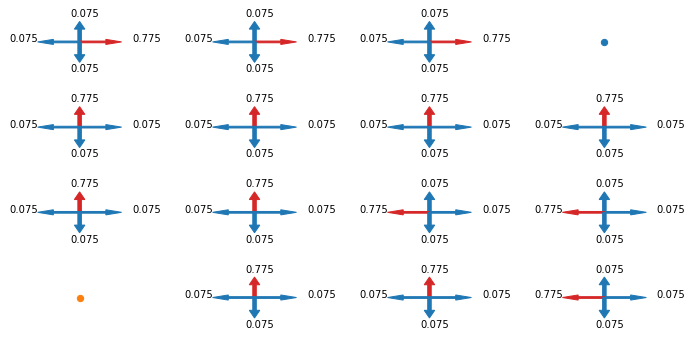

In [5]:
Q1 = on_policy_fv_mc_control(maze, actions, discount=1.0)
show_policy(maze, Q1)

#### First-visit MC control met discount van 0.9

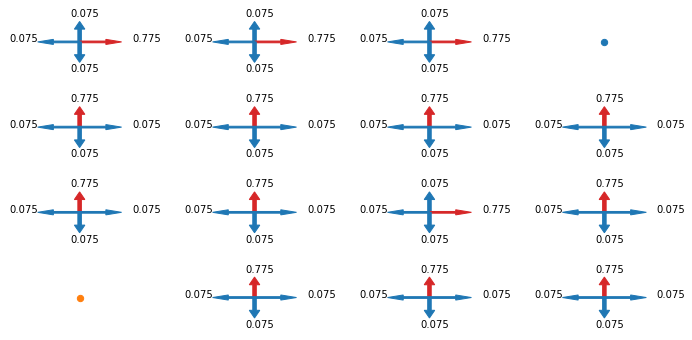

In [6]:
Q1 = on_policy_fv_mc_control(maze, actions, discount=0.9)
show_policy(maze, Q1)

### SARSA

In [7]:
def sarsa(env: Maze, actions: List[str], discount: float = 0.9, step_size: float = 0.1,
          epsilon: float = 0.3, n_episodes: int = 10000):
    """A function that uses Sarsa (on-policy TD control) to optimise for the best policy.
    
    args:
        env (Maze): The environment which holds the rewards of all the possible states.
        actions (List[str]): The action space.
        discount (float, optional): The discount factor. Defaults to 0.9.
        step_size (float, optional): The size of the step towards the target. Defaults to 0.1.
        epsilon (float, optional): The rate of exploration. Defaults to 0.3.
        n_episodes (int, optional): The amount of episodes to run. Defaults to 10000.       

    returns:
        default_dict: The Q-table with the policy.
    """
    # set up the qtable and the state-action returns
    Q_table = defaultdict(lambda: np.zeros(len(actions)))
    
    for _ in range(n_episodes):
        state = env.get_random_position()
        
        # choose the action based on the current state (e-greedy)
        action = epsilon_greedy_step(Q_table, state, epsilon)
        
        while state not in env.end_states:

            # get the next state with the reward
            all_actions = env.get_next_action_positions(state)
            next_state = all_actions[action]
            reward = env.R[next_state]
            
            # choose greedily the next action of the following state
            next_action = epsilon_greedy_step(Q_table, next_state, epsilon)
            
            # calculate the Q-value
            Q_table[state][action] = Q_table[state][action] + step_size * (reward + discount * Q_table[next_state][next_action] - Q_table[state][action])
            
            # update the state and action
            state = next_state
            action = next_action

    return Q_table     

#### Sarsa met discount van 1.0

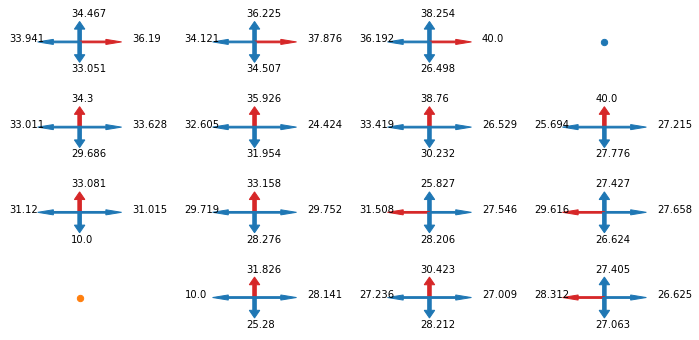

In [8]:
Q1 = sarsa(maze, actions, discount=1.0)
show_policy(maze, Q1)

#### Sarsa met discount van 0.9

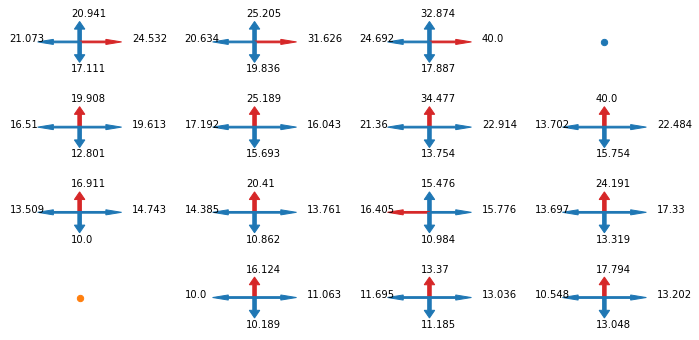

In [9]:
Q1 = sarsa(maze, actions, discount=0.9)
show_policy(maze, Q1)

### Q-Learning (SARSAMAX)

In [10]:
def q_learning(env: Maze, actions: List[str], discount: float = 0.9, step_size: float = 0.1,
          epsilon: float = 0.3, n_episodes: int = 10000):
    """A function that uses Q-Learning (off-policy TD control) to optimise for the best policy.
    
    args:
        env (Maze): The environment which holds the rewards of all the possible states.
        actions (List[str]): The action space.
        discount (float, optional): The discount factor. Defaults to 0.9.
        step_size (float, optional): The size of the step towards the target. Defaults to 0.1.
        epsilon (float, optional): The rate of exploration. Defaults to 0.3.
        n_episodes (int, optional): The amount of episodes to run. Defaults to 10000.       

    returns:
        default_dict: The Q-table with the policy.
    """
    # set up the qtable and the state-action returns
    Q_table = defaultdict(lambda: np.zeros(len(actions)))
    
    for _ in range(n_episodes):
        state = env.get_random_position()
        
        while state not in env.end_states:
            
            # choose the action based on the current state (e-greedy)
            action = epsilon_greedy_step(Q_table, state, epsilon)

            # get the next state with the reward
            all_actions = env.get_next_action_positions(state)
            next_state = all_actions[action]
            reward = env.R[next_state]
            
            # calculate the Q-value
            Q_table[state][action] = Q_table[state][action] + step_size * (reward + discount * np.amax(Q_table[next_state]) - Q_table[state][action])
            
            # update the state and action
            state = next_state

    return Q_table

#### Q-learning met discount van 1.0

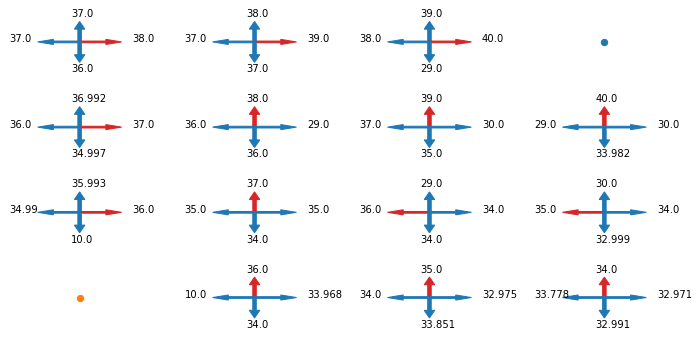

In [11]:
Q1 = q_learning(maze, actions, discount=1.0)
show_policy(maze, Q1)

#### Q-learning met discount van 0.9

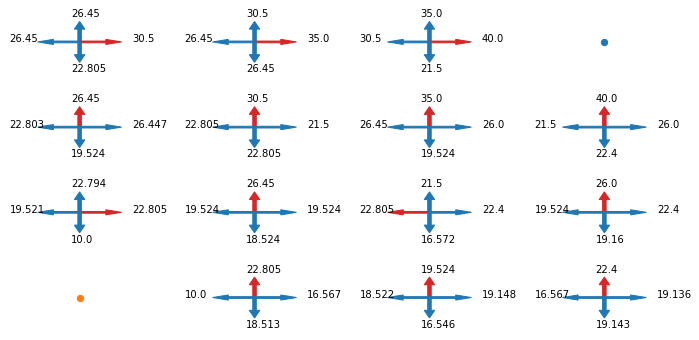

In [12]:
Q1 = q_learning(maze, actions, discount=0.9)
show_policy(maze, Q1)